In [2]:
import numpy as np
from utils import *
from keras import callbacks
import tensorflow as tf
import time
from tqdm import tqdm

In [3]:
IMG_SIZE=32

# Set the path to the folder containing the image data
data_path = '../dataset/input_resized_256/flowers/'

# Create an instance of the DimReductionEvaluation class
dre = DimReductionEvaluation()
dre.load_data(data_path, IMG_SIZE)

## Visualizeing Neural Networks

Model: "sequential_200"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_500 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_200 (MaxPooli  (None, 16, 16, 16)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_1000 (B  (None, 16, 16, 16)       64        
 atchNormalization)                                              
                                                                 
 conv2d_501 (Conv2D)         (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_201 (MaxPooli  (None, 8, 8, 32)         0         
 ng2D)                                                           
                                                    

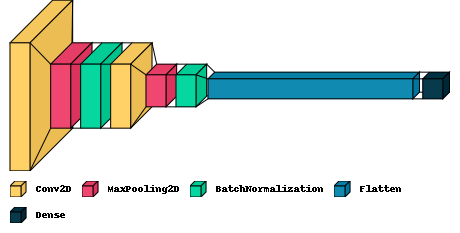

In [11]:


batch_size=32
dae_cnn=DAE_CNN(batch_size=batch_size,
                 input_shape=(IMG_SIZE, IMG_SIZE, 3),latent_dim=100)

dae=DAE(batch_size=batch_size,
                 input_dim=IMG_SIZE*IMG_SIZE*3, latent_dim=100)

dae_cnn.encoder.summary()
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(dae_cnn.encoder, legend=True)



Model: "model_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_86 (InputLayer)       [(None, 3072)]            0         
                                                                 
 dense_210 (Dense)           (None, 1536)              4720128   
                                                                 
 batch_normalization_503 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 activation_42 (Activation)  (None, 1536)              0         
                                                                 
 dense_211 (Dense)           (None, 768)               1180416   
                                                                 
 batch_normalization_504 (Ba  (None, 768)              3072      
 tchNormalization)                                        

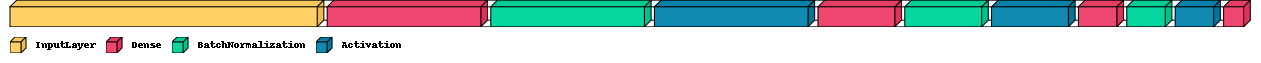

In [84]:
dae.encoder.summary()
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(dae.encoder, legend=True)


In [85]:
x_train, x_test, y_train, y_test = dre.split_data(dre.X, dre.Y, test_size=0.1)
x_train_flat=x_train.reshape(x_train.shape[0], -1)
x_test_flat=x_test.reshape(x_test.shape[0], -1)
x_train_flat.shape

(3885, 3072)

In [100]:
History=dae.fit(x_train_flat, y_train, epochs=100, verbose=1)
# History=dae.autoencoder.fit(
#             x_train_flat,
#             x_train_flat,
#             epochs=100,
#             batch_size=dae.batch_size,
#             validation_data=(x_test_flat, x_test_flat),
#             verbose=1,
#             callbacks=[
#                 callbacks.EarlyStopping(
#                     monitor='val_loss',
#                     min_delta=0.01,
#                     patience=10,
#                     restore_best_weights=True)]
#             )

Epoch 1/100
122/122 [==============================] - 4s 32ms/step - loss: 0.2921 - val_loss: 0.2893
Epoch 2/100
122/122 [==============================] - 3s 27ms/step - loss: 0.2919 - val_loss: 0.2879
Epoch 3/100
122/122 [==============================] - 3s 25ms/step - loss: 0.2918 - val_loss: 0.2880
Epoch 4/100
122/122 [==============================] - 3s 25ms/step - loss: 0.2912 - val_loss: 0.2883
Epoch 5/100
122/122 [==============================] - 3s 23ms/step - loss: 0.2913 - val_loss: 0.2866
Epoch 6/100
122/122 [==============================] - 3s 24ms/step - loss: 0.2905 - val_loss: 0.2871
Epoch 7/100
122/122 [==============================] - 3s 25ms/step - loss: 0.2904 - val_loss: 0.2863
Epoch 8/100
122/122 [==============================] - 3s 23ms/step - loss: 0.2902 - val_loss: 0.2874
Epoch 9/100
122/122 [==============================] - 3s 24ms/step - loss: 0.2898 - val_loss: 0.2856
Epoch 10/100
122/122 [==============================] - 3s 23ms/step - loss: 0.289

In [104]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Range of K values to test
k_range=(np.linspace(0.001, 0.1, 3)*dre.dim).astype(np.int64)
batch_size=32

# Test the performance of the different dimensionality reduction methods
accuracy_DAE_CNN=[]
accuracy_DAE=[]
time_DAE_CNN=[]

x_train, x_test, y_train, y_test = dre.split_data(dre.X, dre.Y, test_size=0.1)
x_train_flat=x_train.reshape(x_train.shape[0], -1)
x_test_flat=x_test.reshape(x_test.shape[0], -1)

# Create a KNN classifier
params = {
        "n_neighbors":
        [i for i in range(1, int(np.sqrt(3)*IMG_SIZE))]
}

random_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=params,
    n_iter=60,
    cv=5,
    n_jobs=-1)
histories=[]

# Make 5 runs
for i in range(1):

    accuracy_DAE_CNN_=[]
    time_DAE_CNN_=[]
    accuracy_DAE_=[]
    time_DAE_=[]

    # Split the data into training and test sets
    x_train, x_test, y_train, y_test = dre.split_data(dre.X, dre.Y, test_size=0.1)
    x_train_flat=x_train.reshape(x_train.shape[0], -1)
    x_test_flat=x_test.reshape(x_test.shape[0], -1) 

    # Fit the k-NN classifier to the training data
    # random_search.fit(x_train_flat, y_train)
    # baseline=random_search.score(x_test_flat, y_test)
    # print('Baseline accuracy: ', baseline)

    # Test the performance for different k values
    for k in tqdm(k_range):
        
        # Create an instance of the DAE class
        s_time=time.time()
        dae_cnn=DAE_CNN(latent_dim=k, batch_size=batch_size,
                         input_shape=(IMG_SIZE, IMG_SIZE, 3))

        dae=DAE(latent_dim=k, batch_size=batch_size,
                    input_dim=IMG_SIZE*IMG_SIZE*3)
        
        # Fit the DAE to the training data
        History=dae_cnn.fit(x_train, y_train, epochs=150, verbose=1)
        histories.append(History)
        dae.fit(x_train_flat, y_train, epochs=150, verbose=1)

        # Evaluate the performance of the DAE
        time_DAE_CNN_.append(time.time()-s_time)
        random_search.fit(dae_cnn.transform(x_train), y_train)
        accuracy_DAE_CNN_.append(random_search.score(dae_cnn.transform(x_test), y_test))
        print('Accuracy: ', accuracy_DAE_CNN_[-1]
              , 'Time: ', time_DAE_CNN_[-1])
        
        random_search.fit(dae.transform(x_train_flat), y_train)
        accuracy_DAE_.append(random_search.score(dae.transform(x_test_flat), y_test))
        print('Accuracy: ', accuracy_DAE_[-1])

    accuracy_DAE_CNN.append(accuracy_DAE_CNN_)
    accuracy_DAE.append(accuracy_DAE_)
    time_DAE_CNN.append(time_DAE_CNN_)

accuracy_DAE_CNN=np.array(accuracy_DAE_CNN).transpose()
accuracy_DAE=np.array(accuracy_DAE).transpose()

time_DAE_CNN=np.array(time_DAE_CNN).transpose()


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/150
122/122 [==============================] - 7s 45ms/step - loss: 0.4870 - val_loss: 0.3487
Epoch 2/150
122/122 [==============================] - 2s 20ms/step - loss: 0.3415 - val_loss: 0.3215
Epoch 3/150
122/122 [==============================] - 2s 19ms/step - loss: 0.3341 - val_loss: 0.3083
Epoch 4/150
122/122 [==============================] - 2s 19ms/step - loss: 0.3212 - val_loss: 0.3029
Epoch 5/150
122/122 [==============================] - 2s 19ms/step - loss: 0.3179 - val_loss: 0.2991
Epoch 6/150
122/122 [==============================] - 2s 19ms/step - loss: 0.3167 - val_loss: 0.3042
Epoch 7/150
122/122 [==============================] - 2s 18ms/step - loss: 0.3161 - val_loss: 0.2985
Epoch 8/150
122/122 [==============================] - 2s 18ms/step - loss: 0.3145 - val_loss: 0.2979
Epoch 9/150
122/122 [==============================] - 2s 18ms/step - loss: 0.3134 - val_loss: 0.2963
Epoch 10/150
122/122 [==============================] - 2s 18ms/step - loss: 0.312

/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 8ms/step
Accuracy:  0.3287037037037037 Time:  105.94603490829468
122/122 [==============================] - 1s 4ms/step


/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 15ms/step


 33%|███▎      | 1/3 [01:48<03:37, 108.84s/it]

Accuracy:  0.3449074074074074
Epoch 1/150
122/122 [==============================] - 7s 45ms/step - loss: 0.4540 - val_loss: 0.3362
Epoch 2/150
122/122 [==============================] - 3s 21ms/step - loss: 0.3121 - val_loss: 0.3256
Epoch 3/150
122/122 [==============================] - 2s 20ms/step - loss: 0.3004 - val_loss: 0.3095
Epoch 4/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2915 - val_loss: 0.2944
Epoch 5/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2861 - val_loss: 0.2887
Epoch 6/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2864 - val_loss: 0.2864
Epoch 7/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2815 - val_loss: 0.2850
Epoch 8/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2809 - val_loss: 0.2829
Epoch 9/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2795 - val_loss: 0.2822
Epoch 10/150
122/122 [==============================

/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 11ms/step
Accuracy:  0.4537037037037037 Time:  119.1641321182251
122/122 [==============================] - 1s 4ms/step


/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 15ms/step


 67%|██████▋   | 2/3 [03:52<01:57, 117.62s/it]

Accuracy:  0.42592592592592593
Epoch 1/150
122/122 [==============================] - 7s 45ms/step - loss: 0.4514 - val_loss: 0.3379
Epoch 2/150
122/122 [==============================] - 3s 21ms/step - loss: 0.3144 - val_loss: 0.3392
Epoch 3/150
122/122 [==============================] - 2s 20ms/step - loss: 0.2981 - val_loss: 0.3251
Epoch 4/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2915 - val_loss: 0.3058
Epoch 5/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2894 - val_loss: 0.2958
Epoch 6/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2834 - val_loss: 0.2938
Epoch 7/150
122/122 [==============================] - 2s 18ms/step - loss: 0.2818 - val_loss: 0.2911
Epoch 8/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2807 - val_loss: 0.2874
Epoch 9/150
122/122 [==============================] - 2s 19ms/step - loss: 0.2794 - val_loss: 0.2864
Epoch 10/150
122/122 [=============================

/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 14ms/step
Accuracy:  0.3958333333333333 Time:  114.54768991470337
122/122 [==============================] - 1s 4ms/step


/Users/visyn/.virtualenvs/hwenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14/14 [==============================] - 0s 19ms/step


100%|██████████| 3/3 [05:53<00:00, 117.69s/it]

Accuracy:  0.4537037037037037


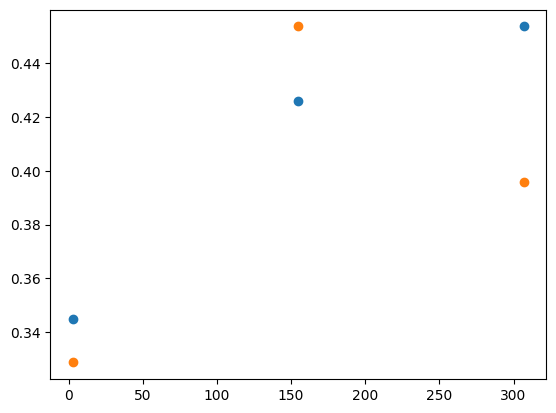

In [105]:
import matplotlib.pyplot as plt
plt.plot(k_range, accuracy_DAE, 'o')
plt.plot(k_range, accuracy_DAE_CNN, 'o')

In [ ]:
model1=tf.keras.models.load_model('../models/CNN_model_1.h5')

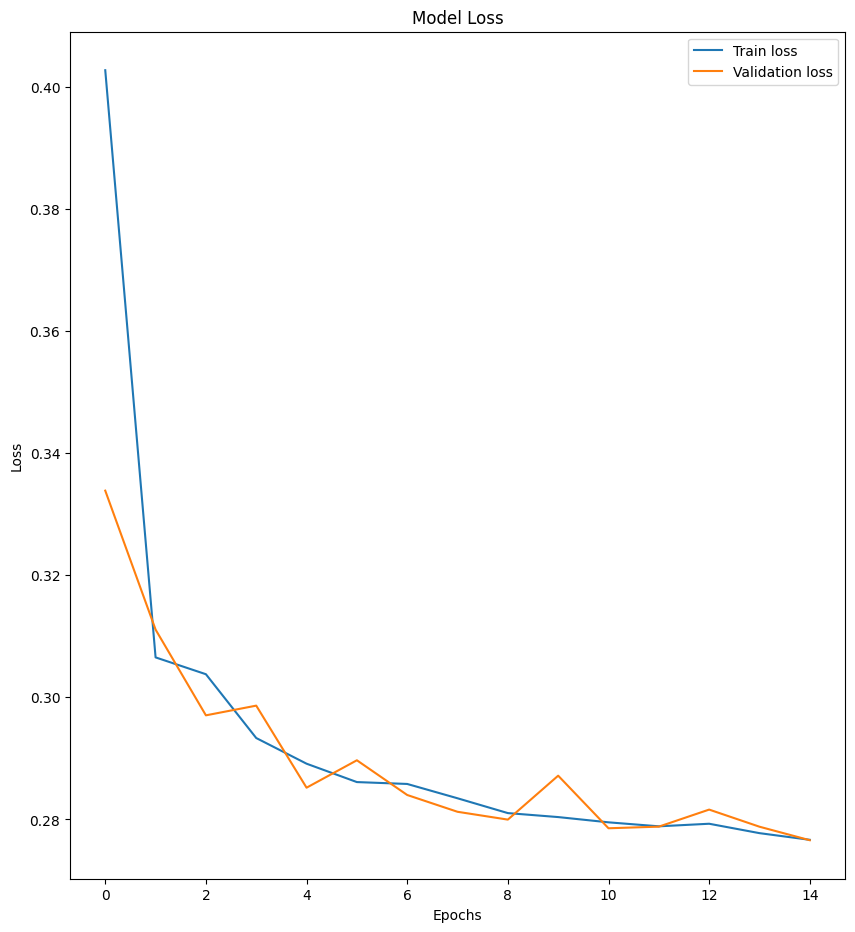

In [232]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,11))

plt.plot(History.history['loss'], label='Train loss')
plt.plot(History.history['val_loss'], label='Validation loss')

plt.legend()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [43]:
from utils import ReductionAnalysis
k_range=np.concatenate(((np.linspace(0.0005, 0.01, 10)*dre.dim).astype(np.int64), 
(np.linspace(.02, 0.1, 10)*dre.dim).astype(np.int64)))
re=ReductionAnalysis(dre.X, dre.Y, k_range, batch_size=32)
re.zero_results()
methods=['SRP', 'RP', 'PCA', 'DAE', 'DAE_CNN']
re.set_k_range(k_range)


In [10]:
re.zero_results()
re.set_k_range(k_range)
for i in range(5):
    print(k_range)
    re.split_data()
    re.evaluate(methods=methods, verbose=0)
    re.results.to_csv('../saved_calculations/ReductionAnalysis.csv')

[  1   4   8  11  14  17  20  24  27  30  61  88 116 143 170 197 225 252
 279 307]


  0%|          | 0/20 [00:00<?, ?it/s]

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-04-16 11:47:23.972051: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 3ms/step


  5%|▌         | 1/20 [00:41<13:16, 41.91s/it]

14/14 [==============================] - 0s 4ms/step


 10%|█         | 2/20 [01:40<15:25, 51.44s/it]

14/14 [==============================] - 0s 4ms/step


 15%|█▌        | 3/20 [02:48<16:46, 59.22s/it]

14/14 [==============================] - 0s 3ms/step


 20%|██        | 4/20 [03:45<15:31, 58.21s/it]

14/14 [==============================] - 0s 4ms/step


 25%|██▌       | 5/20 [04:42<14:26, 57.76s/it]

14/14 [==============================] - 0s 4ms/step


 30%|███       | 6/20 [05:42<13:40, 58.61s/it]

14/14 [==============================] - 0s 5ms/step


 35%|███▌      | 7/20 [06:44<12:58, 59.86s/it]

14/14 [==============================] - 0s 5ms/step


 40%|████      | 8/20 [07:35<11:25, 57.09s/it]

14/14 [==============================] - 0s 5ms/step


 45%|████▌     | 9/20 [08:40<10:51, 59.27s/it]

14/14 [==============================] - 0s 7ms/step


 50%|█████     | 10/20 [09:46<10:14, 61.48s/it]

14/14 [==============================] - 0s 4ms/step


 55%|█████▌    | 11/20 [10:57<09:40, 64.49s/it]

14/14 [==============================] - 0s 6ms/step


 60%|██████    | 12/20 [12:02<08:37, 64.67s/it]

14/14 [==============================] - 0s 6ms/step


 65%|██████▌   | 13/20 [13:08<07:34, 64.93s/it]

14/14 [==============================] - 0s 5ms/step


 70%|███████   | 14/20 [14:27<06:55, 69.27s/it]

14/14 [==============================] - 0s 6ms/step


 75%|███████▌  | 15/20 [15:41<05:53, 70.73s/it]

14/14 [==============================] - 0s 7ms/step


 80%|████████  | 16/20 [16:54<04:44, 71.25s/it]

14/14 [==============================] - 0s 6ms/step


 85%|████████▌ | 17/20 [18:02<03:31, 70.46s/it]

14/14 [==============================] - 0s 6ms/step


 90%|█████████ | 18/20 [19:18<02:24, 72.16s/it]

14/14 [==============================] - 0s 6ms/step


 95%|█████████▌| 19/20 [20:33<01:12, 72.80s/it]

14/14 [==============================] - 0s 7ms/step


100%|██████████| 20/20 [21:41<00:00, 65.08s/it]


[  1   4   8  11  14  17  20  24  27  30  61  88 116 143 170 197 225 252
 279 307]


  0%|          | 0/20 [00:00<?, ?it/s]

14/14 [==============================] - 0s 10ms/step


  5%|▌         | 1/20 [01:00<19:02, 60.12s/it]

14/14 [==============================] - 0s 5ms/step


 10%|█         | 2/20 [02:07<19:23, 64.66s/it]

14/14 [==============================] - 0s 6ms/step


 15%|█▌        | 3/20 [03:16<18:49, 66.45s/it]

14/14 [==============================] - 0s 6ms/step


 20%|██        | 4/20 [04:20<17:24, 65.29s/it]

14/14 [==============================] - 0s 6ms/step


 25%|██▌       | 5/20 [05:32<16:56, 67.80s/it]

14/14 [==============================] - 0s 7ms/step


 30%|███       | 6/20 [06:40<15:52, 68.03s/it]

14/14 [==============================] - 0s 10ms/step


 35%|███▌      | 7/20 [07:54<15:08, 69.89s/it]

14/14 [==============================] - 0s 5ms/step


 40%|████      | 8/20 [08:57<13:33, 67.79s/it]

14/14 [==============================] - 0s 10ms/step


 45%|████▌     | 9/20 [10:00<12:08, 66.23s/it]

14/14 [==============================] - 0s 5ms/step


 50%|█████     | 10/20 [11:15<11:30, 69.06s/it]

14/14 [==============================] - 0s 9ms/step


 55%|█████▌    | 11/20 [12:31<10:39, 71.00s/it]

14/14 [==============================] - 0s 10ms/step


 60%|██████    | 12/20 [13:46<09:37, 72.13s/it]

14/14 [==============================] - 0s 10ms/step


 65%|██████▌   | 13/20 [15:19<09:10, 78.70s/it]

14/14 [==============================] - 0s 8ms/step


 70%|███████   | 14/20 [16:40<07:55, 79.31s/it]

14/14 [==============================] - 0s 10ms/step


 75%|███████▌  | 15/20 [17:50<06:22, 76.49s/it]

14/14 [==============================] - 0s 7ms/step


 80%|████████  | 16/20 [19:14<05:14, 78.59s/it]

14/14 [==============================] - 0s 13ms/step


 85%|████████▌ | 17/20 [20:37<03:59, 79.91s/it]

14/14 [==============================] - 0s 9ms/step


 90%|█████████ | 18/20 [22:09<02:47, 83.72s/it]

14/14 [==============================] - 0s 8ms/step


 95%|█████████▌| 19/20 [23:35<01:24, 84.28s/it]

14/14 [==============================] - 0s 8ms/step


100%|██████████| 20/20 [25:00<00:00, 75.02s/it]


[  1   4   8  11  14  17  20  24  27  30  61  88 116 143 170 197 225 252
 279 307]


  0%|          | 0/20 [00:00<?, ?it/s]

14/14 [==============================] - 0s 8ms/step


  5%|▌         | 1/20 [01:03<19:59, 63.13s/it]

14/14 [==============================] - 0s 9ms/step


 10%|█         | 2/20 [02:05<18:48, 62.71s/it]

14/14 [==============================] - 0s 8ms/step


 15%|█▌        | 3/20 [03:18<19:09, 67.62s/it]

14/14 [==============================] - 0s 8ms/step


 20%|██        | 4/20 [04:36<19:02, 71.38s/it]

14/14 [==============================] - 0s 8ms/step


 25%|██▌       | 5/20 [05:47<17:51, 71.41s/it]

14/14 [==============================] - 0s 9ms/step


 30%|███       | 6/20 [07:00<16:48, 72.06s/it]

14/14 [==============================] - 0s 13ms/step


 35%|███▌      | 7/20 [08:20<16:08, 74.52s/it]

14/14 [==============================] - 0s 12ms/step


 40%|████      | 8/20 [09:34<14:51, 74.29s/it]

14/14 [==============================] - 0s 14ms/step


 45%|████▌     | 9/20 [10:56<14:05, 76.90s/it]

14/14 [==============================] - 0s 11ms/step


 50%|█████     | 10/20 [12:08<12:32, 75.29s/it]

14/14 [==============================] - 0s 13ms/step


 55%|█████▌    | 11/20 [13:39<12:00, 80.05s/it]

14/14 [==============================] - 0s 9ms/step


 60%|██████    | 12/20 [15:09<11:04, 83.09s/it]

14/14 [==============================] - 0s 13ms/step


 65%|██████▌   | 13/20 [16:29<09:35, 82.27s/it]

14/14 [==============================] - 0s 10ms/step


 70%|███████   | 14/20 [17:53<08:15, 82.55s/it]

14/14 [==============================] - 0s 12ms/step


 75%|███████▌  | 15/20 [19:34<07:20, 88.15s/it]

14/14 [==============================] - 0s 12ms/step


 80%|████████  | 16/20 [20:58<05:48, 87.01s/it]

14/14 [==============================] - 0s 19ms/step


 85%|████████▌ | 17/20 [22:24<04:20, 86.70s/it]

14/14 [==============================] - 0s 11ms/step


 90%|█████████ | 18/20 [24:03<03:00, 90.30s/it]

14/14 [==============================] - 0s 9ms/step


 95%|█████████▌| 19/20 [25:34<01:30, 90.45s/it]

14/14 [==============================] - 0s 11ms/step


100%|██████████| 20/20 [27:01<00:00, 81.08s/it]


[  1   4   8  11  14  17  20  24  27  30  61  88 116 143 170 197 225 252
 279 307]


  0%|          | 0/20 [00:00<?, ?it/s]

14/14 [==============================] - 0s 12ms/step


  5%|▌         | 1/20 [01:09<21:53, 69.15s/it]

14/14 [==============================] - 0s 13ms/step


 10%|█         | 2/20 [02:19<21:02, 70.14s/it]

14/14 [==============================] - 0s 11ms/step


 15%|█▌        | 3/20 [03:44<21:42, 76.59s/it]

14/14 [==============================] - 0s 13ms/step


 20%|██        | 4/20 [05:07<21:07, 79.23s/it]

14/14 [==============================] - 0s 17ms/step


 25%|██▌       | 5/20 [06:35<20:37, 82.51s/it]

14/14 [==============================] - 0s 13ms/step


 30%|███       | 6/20 [08:03<19:37, 84.13s/it]

14/14 [==============================] - 0s 13ms/step


 35%|███▌      | 7/20 [09:25<18:07, 83.67s/it]

14/14 [==============================] - 0s 16ms/step


 40%|████      | 8/20 [10:47<16:38, 83.17s/it]

14/14 [==============================] - 0s 17ms/step


 45%|████▌     | 9/20 [12:28<16:14, 88.62s/it]

14/14 [==============================] - 0s 20ms/step


 50%|█████     | 10/20 [14:14<15:40, 94.02s/it]

14/14 [==============================] - 0s 13ms/step


 55%|█████▌    | 11/20 [15:45<13:56, 92.98s/it]

14/14 [==============================] - 0s 15ms/step


 60%|██████    | 12/20 [17:13<12:12, 91.60s/it]

14/14 [==============================] - 0s 13ms/step


 65%|██████▌   | 13/20 [18:56<11:05, 95.01s/it]

14/14 [==============================] - 0s 17ms/step


 70%|███████   | 14/20 [20:34<09:35, 95.96s/it]

14/14 [==============================] - 0s 17ms/step


 75%|███████▌  | 15/20 [22:08<07:56, 95.26s/it]

14/14 [==============================] - 0s 18ms/step


 80%|████████  | 16/20 [23:41<06:18, 94.59s/it]

14/14 [==============================] - 0s 17ms/step


 85%|████████▌ | 17/20 [25:33<04:59, 99.95s/it]

14/14 [==============================] - 0s 14ms/step


 90%|█████████ | 18/20 [27:20<03:23, 101.92s/it]

14/14 [==============================] - 0s 18ms/step


 95%|█████████▌| 19/20 [29:03<01:42, 102.32s/it]

14/14 [==============================] - 0s 23ms/step


100%|██████████| 20/20 [30:50<00:00, 92.51s/it] 


[  1   4   8  11  14  17  20  24  27  30  61  88 116 143 170 197 225 252
 279 307]


  0%|          | 0/20 [00:00<?, ?it/s]

14/14 [==============================] - 0s 18ms/step


  5%|▌         | 1/20 [01:19<25:19, 79.97s/it]

14/14 [==============================] - 0s 14ms/step


 10%|█         | 2/20 [02:53<26:28, 88.24s/it]

14/14 [==============================] - 0s 23ms/step


 15%|█▌        | 3/20 [04:24<25:20, 89.42s/it]

14/14 [==============================] - 0s 17ms/step


 20%|██        | 4/20 [06:07<25:14, 94.67s/it]

14/14 [==============================] - 0s 18ms/step


 25%|██▌       | 5/20 [07:45<23:57, 95.86s/it]

14/14 [==============================] - 0s 19ms/step


 30%|███       | 6/20 [09:11<21:36, 92.57s/it]

14/14 [==============================] - 0s 22ms/step


 35%|███▌      | 7/20 [10:42<19:54, 91.87s/it]

14/14 [==============================] - 0s 21ms/step


 40%|████      | 8/20 [12:27<19:13, 96.10s/it]

14/14 [==============================] - 0s 18ms/step


 45%|████▌     | 9/20 [14:02<17:33, 95.79s/it]

14/14 [==============================] - 0s 15ms/step


 50%|█████     | 10/20 [15:38<15:57, 95.79s/it]

14/14 [==============================] - 0s 19ms/step


 55%|█████▌    | 11/20 [17:10<14:12, 94.68s/it]

14/14 [==============================] - 0s 16ms/step


 60%|██████    | 12/20 [19:15<13:52, 104.09s/it]

14/14 [==============================] - 0s 16ms/step


 65%|██████▌   | 13/20 [21:16<12:44, 109.19s/it]

14/14 [==============================] - 0s 16ms/step


 70%|███████   | 14/20 [23:04<10:53, 108.86s/it]

14/14 [==============================] - 0s 15ms/step


 75%|███████▌  | 15/20 [24:42<08:46, 105.39s/it]

14/14 [==============================] - 0s 20ms/step


 80%|████████  | 16/20 [26:26<07:00, 105.14s/it]

14/14 [==============================] - 0s 21ms/step


 85%|████████▌ | 17/20 [28:21<05:23, 107.86s/it]

14/14 [==============================] - 0s 16ms/step


 90%|█████████ | 18/20 [30:19<03:42, 111.04s/it]

14/14 [==============================] - 0s 27ms/step


 95%|█████████▌| 19/20 [32:06<01:49, 109.85s/it]

14/14 [==============================] - 0s 21ms/step


100%|██████████| 20/20 [33:52<00:00, 101.63s/it]


In [75]:
fname='../saved_calculations/ReductionAnalysis_1.csv'
results = pd.read_csv(fname, dtype={'Index': int, 'method': str,'score':float, 'time': float, 'k': int})
results=results.drop(columns=['Unnamed: 0'])
accuracy=[]
for k in results['k'].unique():
        tmp=results[results['k']==k]
        tmp=tmp[tmp['method']==label]
        accuracy.append(tmp['score'].to_numpy())
accuracy=np.array(accuracy)
print(accuracy.shape)

(20, 5)


Series([], Name: method, dtype: float64)

(20, 5)
(20, 5)
(20, 5)
(20, 5)
(20, 5)


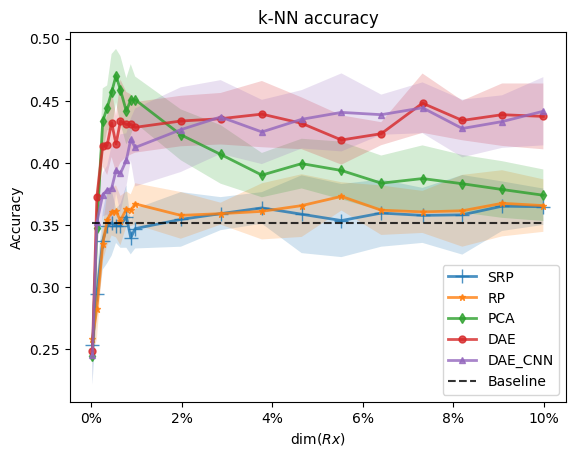

In [79]:
%matplotlib inline
k_range=np.array(results['k'].unique())
fig, ax = plt.subplots()
for plot_style, markersize, linewidth, label in zip(
        ['+-', '*-', 'd-', 'o-', '^-'], [10, 5, 5, 5, 5], [2, 2, 2, 2, 2], methods):
        accuracy=[]
        for k in results['k'].unique():
                tmp=results[results['k']==k]
                tmp=tmp[tmp['method']==label]
                accuracy.append(tmp['score'].to_numpy())
        accuracy=np.array(accuracy)

        ax.plot(k_range*100.0/dre.dim, accuracy.mean(axis=-1), plot_style, markersize=markersize,
                linewidth=linewidth, label=label, alpha=0.8)
        ax.fill_between(k_range*100.0/dre.dim, accuracy.mean(axis=-1) - accuracy.std(axis=-1),
                        accuracy.mean(axis=-1) + accuracy.std(axis=-1), alpha=0.2)
        
ax.plot(k_range*100.0/dre.dim, np.ones_like(k_range)*baseline,
         'k--', label='Baseline', alpha=0.8)

# ax.legend(loc='best')
ax.legend(loc='lower right')#, bbox_to_anchor=(1.2, 1.0))
ax.set_xlabel(r'dim($Rx$)')
ax.set_ylabel('Accuracy')

# Format the tick labels to show a percentage sign
import matplotlib.ticker as ticker
fmt = '%.0f%%'
xticks = ticker.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
ax.set_title('k-NN accuracy')
plt.show()

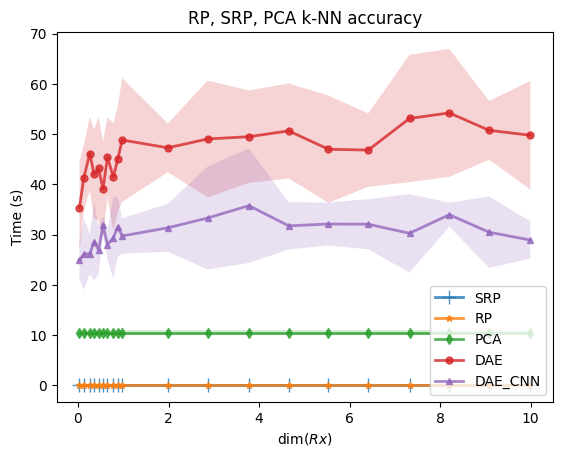

In [42]:
%matplotlib inline
results=re.results
k_range=np.array(results['k'].unique())
fig, ax = plt.subplots()
for plot_style, markersize, linewidth, label in zip(
        ['+-', '*-', 'd-', 'o-', '^-'], [10, 5, 5, 5, 5], [2, 2, 2, 2, 2], methods):
        accuracy=[]
        for k in results['k'].unique():
                tmp=results[results['k']==k]
                tmp=tmp[tmp['method']==label]
                accuracy.append(tmp['time'].to_numpy())
        accuracy=np.array(accuracy)
        ax.plot(k_range/dre.dim*100, accuracy.mean(axis=-1), plot_style, markersize=markersize,
                linewidth=linewidth, label=label, alpha=0.8)
        ax.fill_between(k_range/dre.dim*100, accuracy.mean(axis=-1) - accuracy.std(axis=-1),
                        accuracy.mean(axis=-1) + accuracy.std(axis=-1), alpha=0.2)

# ax.legend(loc='best')
ax.legend(loc='lower right')#, bbox_to_anchor=(1.2, 1.0))
ax.set_xlabel(r'dim($Rx$)')
ax.set_ylabel('Time (s)')
ax.set_title('RP, SRP, PCA k-NN accuracy')
plt.show()

In [44]:
baseline=re.estimate_baseline()
